In [1]:
import re
from typing import List, Tuple

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 8)})

In [2]:
dataset = read_lang_dataset("data/codes_fin.db")
dataset

,language,code
0,Python,"""""""The tests for the automation component.""""""\..."
1,Python,#!python2\n# -*- coding: utf-8 -*-\nimport os\...
2,Python,#!/usr/bin/python\n#\n# Copyright (c) 2017 Yuw...
3,Python,"""""""The tests for the Template automation.""""""\n..."
4,Python,"""""""The tests for numeric state automation.""""""\..."
...,...,...
9468,C#,using Microsoft.SharePoint.Client;\nusing Micr...
9469,C#,using System;\nusing System.Collections;\nusin...
9470,C#,using UnityEngine;\nusing System.Collections.G...
9471,C#,// Copyright (c) Microsoft Corporation. All ri...


In [3]:
dataset.language.value_counts()

C++       2688
C#        2494
Go        2203
Python    2088
Name: language, dtype: int64

In [18]:
use_cache = True
# load "tokenized_sample.pkl" from disk if it exists
if use_cache and os.path.exists("models/tokenized_sample.pkl"):
    tokenized_sample = pd.read_pickle("models/tokenized_sample.pkl")
else:
    tokenized_sample = tokenize_dataset(dataset)
    tokenized_sample.to_pickle("models/tokenized_sample.pkl")

tokenized_sample

,language,code
0,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
1,Python,"[\n, import, os, \n, import, sys, \n, import, ..."
2,Python,"[\n, from, __future__, import, absolute_import..."
3,Python,"[STRING_LITERAL, \n, import, unittest, \n, fro..."
4,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
...,...,...
9468,C#,"[using, Microsoft, ., SharePoint, ., Client, ;..."
9469,C#,"[using, System, ;, using, System, ., Collectio..."
9470,C#,"[using, UnityEngine, ;, using, System, ., Coll..."
9471,C#,"[using, System, ;, using, System, ., Collectio..."


In [5]:
def create_lang_model(dataset, complete_model, language):
    model = Word2Vec.load("models/complete_model.gensim")
    #model = FastText.load("models/complete_model.gensim")
    #model = Word2Vec(vector_size=100, window=10, min_count=10, workers=4)
    #model.reset_from(complete_model)
    #model.init_weights()
    train_dataset = dataset.code[dataset.language == language]
    model.train(train_dataset, total_examples=len(train_dataset), epochs=5)
    return model

In [95]:
common_keywords = ["if", "else", "for", "while", "class", "struct", "return", "continue", "break", "var", "try", "catch", "except"]
semantic_symbols = ["{", "}", ":"]

language_specific_words = common_keywords + semantic_symbols

In [70]:
from functools import partial


def add_language_prefix(code, language):
    return [f"{language}_{keyword}" if keyword in language_specific_words else keyword for keyword in code]

for language in tokenized_sample.language.unique():
    tokenized_sample.loc[tokenized_sample.language == language, "code"] = tokenized_sample[tokenized_sample.language == language].code.apply(partial(add_language_prefix, language=language))

In [92]:
#complete_model = FastText(vector_size=100, window=5, min_count=5, workers=8)
#complete_model = Word2Vec(vector_size=500, window=5, min_count=10, workers=8)
complete_model = FastText(vector_size=100, window=5, min_count=10, workers=8)
complete_model.build_vocab(tokenized_sample.code)
complete_model.train(tokenized_sample.code, total_examples=complete_model.corpus_count, epochs=5)
complete_model

# Visualize

In [64]:
inserted_tokens = ["INT_LITERAL", "FLOAT_LITERAL", "STRING_LITERAL", "VARIABLE"]
math_ops = ["+", "-", "*", "/", "%", "&&", "||", "!", "&", "|"]

python_keywords = ["def", "class", "return", "if", "else", "for", "while", "in", "import", "from", "as", "with", "try", "except", "finally", "raise", "assert", "yield", "lambda", "pass", "break", "continue", "del", "global", "nonlocal", "and", "or", "not", "is", "in", "True", "False", "None", "async", "await"]
cpp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
csharp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
go_keywords = ["break", "func", "default", "type", "defer", "go", "struct", "map", "chan", "else", "goto", "package", "range", "const", "fallthrough", "for", "import", "interface", "return", "select", "case", "continue", "if", "switch", "var", "nil", "true", "false"]

In [98]:
def word_cloud(model: Word2Vec, words):
    words = [word for word in words if word in model.wv.key_to_index.keys()]
    word_vectors = np.array([model.wv.get_normed_vectors()[model.wv.key_to_index[word]] for word in words])
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)

    df = pd.DataFrame(result, columns=["x", "y"])
    df["model"] = [word.split("_")[0] if len(word.split("_")) == 2 else "" for word in words]
    ax = sns.scatterplot(data=df, x="x", y="y", hue="model")
    range_x, range_y = np.ptp(df[["x", "y"]], axis=0)
    keywords = [word.split("_")[1] if len(word.split("_")) == 2 else word for word in words]
    for i, word in enumerate(keywords):
        x, y = result[i]
        ax.text(x + 0.005 * range_x, y, word, verticalalignment='center', horizontalalignment='left', fontsize=8)
    return ax

<AxesSubplot: xlabel='x', ylabel='y'>

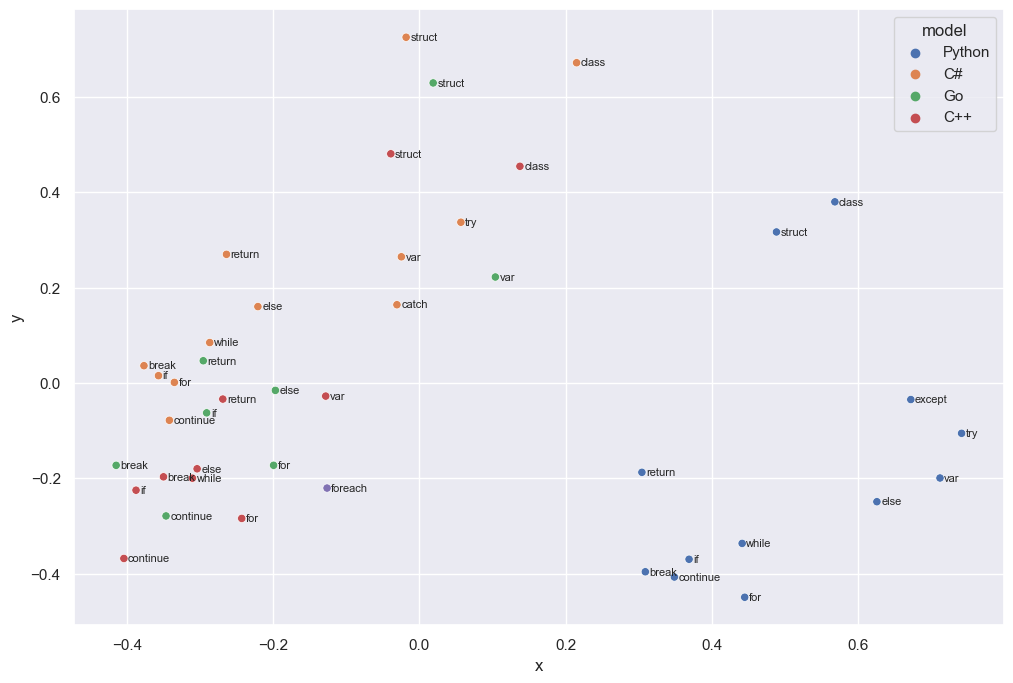

In [99]:
word_cloud(complete_model, [f"{language}_{w}" for w in common_keywords for language in tokenized_sample.language.unique()] + ["foreach"])

In [108]:
# evaluate the model performance
complete_model.predict_output_word(["C#_var", "VARIABLE"])

[('C#_var', 0.0160809),
 ('new', 0.015235802),
 ('await', 0.010560422),
 ('GetEmailAccountOfMessageTemplate', 0.007088959),
 ('using', 0.0059325644),
 ('out', 0.0053956774),
 ('GetResponseStream', 0.0041278144),
 ('Replace', 0.0034895958),
 ('CreateInstallCommand', 0.0030178968),
 ('Uri', 0.0029380445)]